In [2]:
import numpy as np
import pandas as pd

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler


# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#### Read in Data

In [3]:
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (7011, 62)
Testing Feature Size:   (2337, 62)
Training Labels Size:   (7011, 1)
Testing Labels Size:    (2337, 1)


## **Evaluating and Comparing ML models**

Build, train, and evalute several machine learning methods for our supervised regression task. The objective is to determine which model holds the most promise for further development (such as hyperparameter tuning).

Reminder: we are comparing models using the mean absolute error. A baseline model that guessed the median value of the score was off by an average of 25 points.

### Imputing missing values

In P1, we discarded features with missing value > 50%. Now we "impute" the rest of the missing values with simply the **median** of the column. Median imputation usually works well.

- Fit with ONLY training set
- Transform on BOTH train and tests

In [4]:
imputer = SimpleImputer(strategy = "median")

imputer.fit(train_features)

X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [7]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


In [5]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


#### Scaling features

Linear Regression and Random Forest do not require feature scaling, but KNN and SVM do require scaling (euclidean distance matters)

- Fit with ONLY training set
- Transform on BOTH train and tests

In [6]:
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X)

X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [8]:
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

### Models to evaluate

- Linear Regression
- Support Vector Machine Regression
- Random Forest Regression
- Gradient Boosting Regression
- K-Nearest Neighbors Regression

First we compare the models with default hyperparameters, than we select the best one and optimize it

In [9]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

def fit_and_evaluate(model):
    
    #train
    model.fit(X,y)
    
    #predict
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    return model_mae

In [10]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print("The Linear Regression performance on the test set: MAE = %0.4f" % lr_mae)

The Linear Regression performance on the test set: MAE = 13.2185


In [11]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print("The SVR performance on the test set: MAE = %0.4f" % svm_mae)

The SVR performance on the test set: MAE = 10.7707


In [13]:
random_forest = RandomForestRegressor(random_state = 1284)
random_forest_mae = fit_and_evaluate(random_forest)

print("The random forest regression performance on the test set: MAE = %0.4f" % random_forest_mae)

The random forest regression performance on the test set: MAE = 9.2402


In [28]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 9.7103


In [30]:
knn = KNeighborsRegressor(n_neighbors=5)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 12.4326


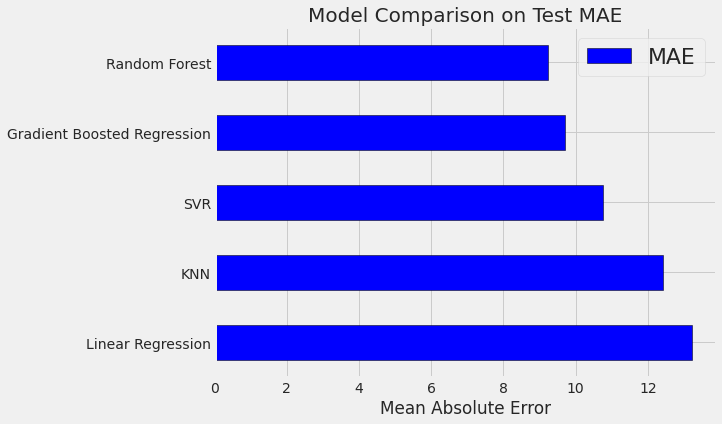

In [40]:
plt.style.use("fivethirtyeight")
figsize(8,6)

# DataFrame to store the results
model_comparison = pd.DataFrame({"Models" : ['Linear Regression', 'SVR', 'Random Forest','Gradient Boosted Regression', 'KNN'],
                                'MAE' : [lr_mae, svm_mae, random_forest_mae, gradient_boosted_mae, knn_mae]})

model_comparison.sort_values('MAE', ascending = False).plot(x = 'Models', y = 'MAE', kind = 'barh', color = 'blue', edgecolor = 'black')

plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

It is not definite that random forest actually outperforms the other ML models, because hyperparameters do matter a lot in some models such as SVR. However, ML models certainly peroform better than the baseline guess. Here we will proceed with random forest.

## **Model Optimization**

### Hyperparameter tuning with Random Search and CV (Random Forest)

Hyperparameters of Random Forest:
- max_depth
- min_sample_split
- max_leaf_nodes
- min_samples_leaf
- n_estimators
- max_sample (bootstrap sample)
- max_features

In [27]:
# Grid of hyperparameters
max_depth = [5, 10, 20, 30, 40, 50, None]
min_samples_split = [2, 4, 6, 8, 10]
#max_leaf_nodes = [None, 2, 6, 10, 14, 18]
min_samples_leaf = [1,2,4,6,8]
n_estimators = [50, 100, 200, 350, 500]
max_samples = [None, 0.1, 0.2, 0.4, 0.8, 1]
max_features = ["auto", "sqrt", "log2", None]

hyperparameter_grid = {"max_depth" : max_depth, "min_samples_split": min_samples_split, 
                       "min_samples_leaf":min_samples_leaf,
                      "n_estimators": n_estimators, "max_samples":max_samples, "max_features":max_features}

In [28]:
model = RandomForestRegressor(random_state = 1284)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=1284)

In [29]:
random_cv.fit(X,y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(random_state=1284),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 20, 30, 40, 50,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'max_samples': [None, 0.1, 0.2, 0.4,
                                                        0.8, 1],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 3, 4, 5, 6],
                                        'n_estimators': [50, 100, 200, 350,
                                                         500]},
                   random_state=1284, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=1)

In [30]:
random_cv.best_estimator_

RandomForestRegressor(max_depth=20, max_features=None, max_samples=0.8,
                      min_samples_split=4, n_estimators=350, random_state=1284)

In [31]:
fit_and_evaluate(random_cv.best_estimator_)

9.243546981016861

In [32]:
# now use grid search to optimize an visualize one hyperparameters
tree_grid = {"n_estimators":[10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = RandomForestRegressor(max_depth=11, max_features=None, max_samples=0.1,
                      min_samples_leaf=6, min_samples_split=5,
                      random_state=1284)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid=tree_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [33]:
grid_search.fit(X, y)

Fitting 4 folds for each of 17 candidates, totalling 68 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:  1.6min finished


GridSearchCV(cv=4,
             estimator=RandomForestRegressor(max_depth=11, max_features=None,
                                             max_samples=0.1,
                                             min_samples_leaf=6,
                                             min_samples_split=5,
                                             random_state=1284),
             n_jobs=-1,
             param_grid={'n_estimators': [10, 50, 100, 150, 200, 250, 300, 350,
                                          400, 450, 500, 550, 600, 650, 700,
                                          750, 800]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

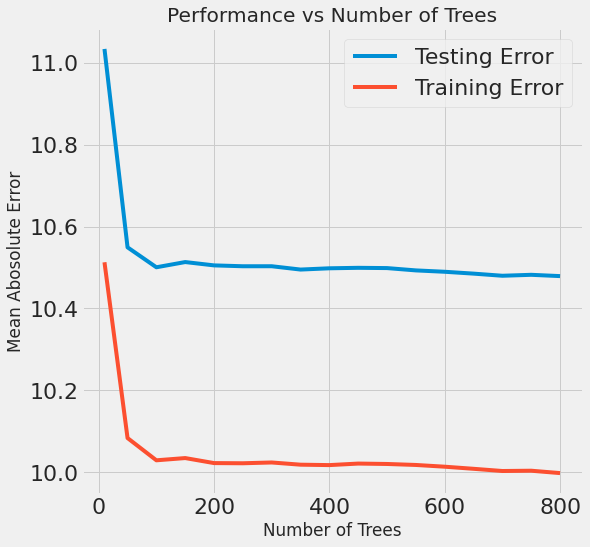

In [34]:
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

## **Evaluate Final Model on the Test Set**

In [35]:
default_model = RandomForestRegressor(random_state = 1284)

final_model = random_cv.best_estimator_

final_model

RandomForestRegressor(max_depth=20, max_features=None, max_samples=0.8,
                      min_samples_split=4, n_estimators=350, random_state=1284)

In [36]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

11.4 s ± 833 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [ ]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

In [24]:
default_predict = default_model.predict(X_test)
final_predict = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_predict))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_predict))

Default model performance on the test set: MAE = 9.2402.
Final model performance on the test set:   MAE = 10.3206.


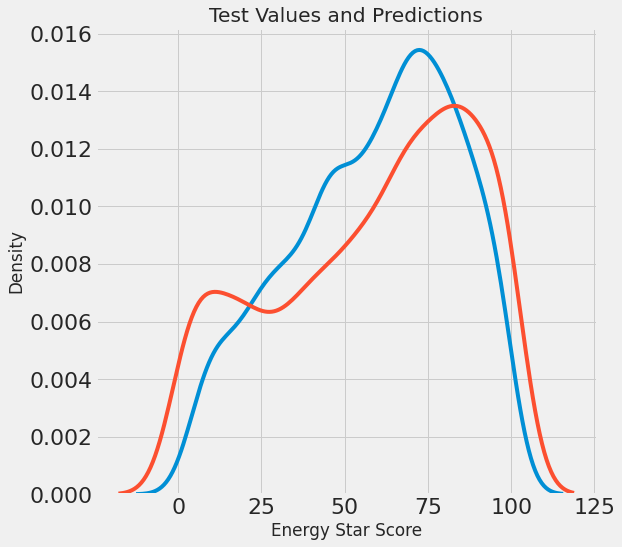

In [26]:
figsize(8, 8)

# Density plot of the final predictions and the test values
sns.kdeplot(final_predict, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

Not a very good prediction, the largest problem is we chose the wrong ML model at the first place. It would be good to redo the process using another ML model.

Another diagnostic plot is a histogram of the residuals. Ideally, we would hope that the residuals are normally distributed, meaning that the model is wrong the same amount in both directions (high and low).

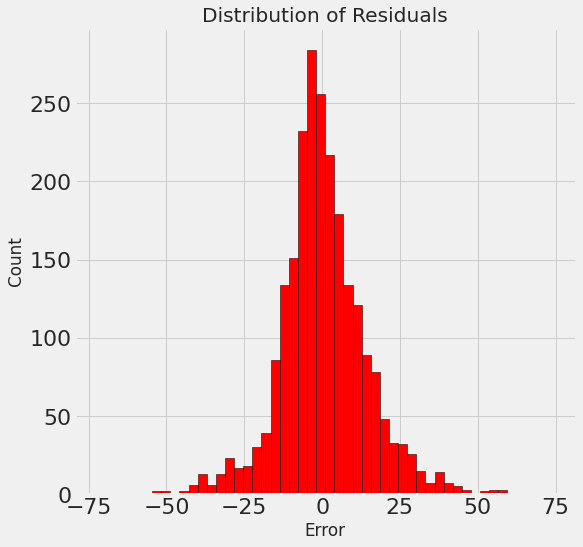

In [76]:
figsize = (6, 6)

# Calculate the residuals 
residuals = final_predict - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 50,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals');

### Hyperparameter tuning with Random Search and CV (SVR)